# Fundation: Layer check 

To implement fully-connected networks using a more modular approach, a more modular design is applied to  build networks. Such that, we can implement different layer types in isolation and then snap them together into models with different architectures.

For each layer, we will implement a forward and a backward function. The forward function will receive inputs, weights, and other parameters  and will return both an output and a cache object storing data needed for the backward pass, like this:
```python
    def layer_forward(x, w):
      # Receive inputs x and weights w 
      # Do some computations ...
      z = # ... some intermediate value
      # Do some more computations ...
      out = # the output

      cache = (x, w, z, out) # Values we need to compute gradients

      return out, cache
```
The backward pass will receive upstream derivatives and the cache object, 
and will return gradients with respect to the inputs and weights, like this:
```python
    def layer_backward(dout, cache):
      # Unpack cache values
      x, w, z, out = cache

      # Use values in cache to compute derivatives
      dx = # Derivative of loss with respect to x
      dw = # Derivative of loss with respect to w

      return dx, dw
```

## 2. Basic Settins and functions

In [1]:
import time
import numpy as np
from CS231n.layer_utils import *
from CS231n.classifiers.fc_net import TwoLayerNet
from CS231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array

import matplotlib.pyplot as plt
%matplotlib inline

# Optional setting
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

## Gradients check
**Use the centered formula. **
$$
\frac{{df\left( x \right)}}{{dx}} = \frac{{f\left( {x + h} \right) - f\left( {x - h} \right)}}{{2h}}
$$

This requires you to evaluate the loss function twice to check every single dimension of the gradient (so it is about 2 times as expensive), but the gradient approximation turns out to be much more precise. To see this, you can use Taylor expansion of $f(x+h)$ and $f(x−h)$ and verify that the first formula has an error on order of $O(h)$, while the second formula only has error terms on order of $O(h^2)$ (i.e. it is a second order approximation).

**Use relative error for the comparison. **

What are the details of comparing the numerical gradient ${f'_n}$ and analytic gradient ${f'_a}$? That is, how do we know if the two are not compatible? You might be temped to keep track of the difference $\left| {{{f'}_n} - {{f'}_a}} \right|$ or its square and define the gradient check as failed if that difference is above a threshold. However, this is problematic. For example, consider the case where their difference is 1e-4. This seems like a very appropriate difference if the two gradients are about 1.0, so we’d consider the two gradients to match. But if the gradients were both on order of 1e-5 or lower, then we’d consider 1e-4 to be a huge difference and likely a failure. Hence, it is always more appropriate to consider the **relative error**:
$$
\frac{{\left| {{{f'}_n} - {{f'}_a}} \right|}}{{\max \left( {\left| {{{f'}_n}} \right|,\left| {f'} \right|} \right)}}
$$

In [2]:
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## 3.1.  Affine layer: forward

for affine, we cache the input image, weigths and biases

In [3]:
input_shape = (2, 4, 5, 6)
output_dim = 3

input_size = np.prod(input_shape)
weight_size = output_dim *  np.prod(input_shape[1:])

x = np.linspace(-0.1, 0.5, num=input_size).reshape(input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape[1:]), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)  # affine forward function

correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.76984772881e-10


## 3.2. Affine layer: backward

In [4]:
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)      

dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print( 'Testing affine_backward function:')
print( 'dx error: ', rel_error(dx_num, dx))
print( 'dw error: ', rel_error(dw_num, dw))
print( 'db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  2.87031649194e-10
dw error:  1.55235700564e-10
db error:  3.24162968444e-12


In the function *eval_numerical_gradient_array.py*, we evaluate a numeric gradient for a function that accepts a numpy
 array and returns a numpy array. Here, we use
 
 $$
 \frac{{dL}}{{dx}} = \frac{{dL}}{{df}} \cdot \frac{{df}}{{dx}}
 $$
 
```python
grad = np.zeros_like(x)
it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
while not it.finished:
    ix = it.multi_index

    oldval = x[ix]
    x[ix] = oldval + h
    pos = f(x).copy()
    x[ix] = oldval - h
    neg = f(x).copy()
    x[ix] = oldval

    grad[ix] = np.sum((pos - neg) * df / (2 * h))
    it.iternext()
return grad
```

## 3.3. Relu: forward

In [5]:
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = ReLU_forward(x)

correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print( 'Testing relu_forward function:')
print( 'difference: ', rel_error(out, correct_out) )

Testing relu_forward function:
difference:  4.99999979802e-08


## 3.4. Relu: backward

In [6]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: ReLU_forward(x)[0], x, dout)

_, cache = ReLU_forward(x)

dx = ReLU_backward(dout, cache)

# The error should be around 1e-12
print( 'Testing relu_backward function:')
print( 'dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756020245e-12


## 3.5. Cascade layer

In this test, an **affie-Relu forward** layer is built.

In [7]:
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)        # forward pass
dx, dw, db = affine_relu_backward(dout, cache)   # backward pass

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print( 'Testing affine_relu_forward:')
print( 'dx error: ', rel_error(dx_num, dx))
print( 'dw error: ', rel_error(dw_num, dw))
print( 'db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  1.81935694598e-10
dw error:  1.54564822949e-09
db error:  1.65922384175e-11


## 3.6. Loss layer: Softmax and SVM

In this test, softmax and SVM loss layer is implemented in vectorization way to accelerate the calculation.

*svm_loss*: computes the loss and gradient using for multiclass SVM classification
```python
N = x.shape[0]

# loss 
correct_class_scores = x[np.arange(N), y]
margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
margins[np.arange(N), y] = 0   # neglect the score reject to the groundtruth label
loss = np.sum(margins) / N     # normarlize

# gradient
dx = np.zeros_like(x)          # d(Loss) / d(score)
dx[margins > 0] = 1            # j != y_i, dx[:,j]=1, dx[:,y_i]=-1. dx[margin>0] include y_i.

dx[np.arange(N), y] = -1*(x.shape[1] -1) # correct gradient of dx[:,y_i]

dx /= N 

return loss, dx  
```

*softmax_loss*: computes the loss and gradient using for softmax classification
```python
N = x.shape[0]
    
probs = np.exp(x - np.max(x, axis=1, keepdims=True))  # Numeric stability trick
probs /= np.sum(probs, axis=1, keepdims=True)         # probility of each class for each inpput image

loss = -np.sum(np.log(probs[np.arange(N), y])) / N

dx = probs.copy()
dx[np.arange(N), y] -= 1 
dx /= N
```

In [8]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print( 'Testing svm_loss:')
print( 'loss: ', loss)
print( 'dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print( '\nTesting softmax_loss:')
print( 'loss: ', loss)
print( 'dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  9.00109841419
dx error:  1.40215660067e-09

Testing softmax_loss:
loss:  2.30269540997
dx error:  8.41313601832e-09


## 3.7. Two-Layer network

A two-layer fully-connected neural network with ReLU nonlinearity and  softmax loss that uses a modular layer design. We assume an input dimension of D, a hidden dimension of H, and perform classification over C classes. 

The architecure should be **affine - relu - affine - softmax**.

Step1: Model initialization

In [9]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print( 'Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

Testing initialization ... 


Step2: test forward pass

In [10]:
print( 'Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
[[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
[12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
[12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

Testing test-time forward pass ... 


Step 3: test loss and gradient 

In [11]:
print( 'Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
    print( 'Running numeric gradient check with reg = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)

for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print( '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
Running numeric gradient check with reg =  0.7
W1 relative error: 8.18e-07
W2 relative error: 7.98e-08
b1 relative error: 1.09e-09
b2 relative error: 9.09e-10


## 4.1. Weight initialization

```python
W = 0.01*np.random.randn(D, H)
``` 

Works ~okay for small networks, but problems with deeper networks. For example, 10-layer net with 500 neurons on each
layer, using tanh non-linearities, and initializing as described in last slide.

In [12]:
# assume some unit gaussian 10-D input data
D = np.random.randn(1000, 50)
hidden_layer_size = [500]*10
nonlinearities = ['tanh']*len(hidden_layer_size)

### Weights initialization with weight_scale=0.01

In [25]:
act = {'relu':lambda x: np.maximum(0, x), 'tanh': lambda x: np.tanh(x)}
Hs = {}
for i in range(len(hidden_layer_size)):
    X = D if i == 0 else Hs[i-1] # input at this layer
    fan_in = X.shape[1]
    fan_out = hidden_layer_size[i]
    W = np.random.randn(fan_in, fan_out) * 0.01 # layer initialization
    
    H = np.dot(X, W)                 # matrix multiply
    H = act[nonlinearities[i]](H)    # nonlinearity
     
    Hs[i] = H                        # cache result on this layer

Input layer had mean -0.009835 and std 0.999655
Hidden layer 1 had mean 0.000028 and std 0.070410
Hidden layer 2 had mean 0.000005 and std 0.015548
Hidden layer 3 had mean -0.000007 and std 0.003482
Hidden layer 4 had mean -0.000001 and std 0.000776
Hidden layer 5 had mean 0.000000 and std 0.000172
Hidden layer 6 had mean -0.000000 and std 0.000038
Hidden layer 7 had mean -0.000000 and std 0.000009
Hidden layer 8 had mean 0.000000 and std 0.000002
Hidden layer 9 had mean 0.000000 and std 0.000000
Hidden layer 10 had mean 0.000000 and std 0.000000


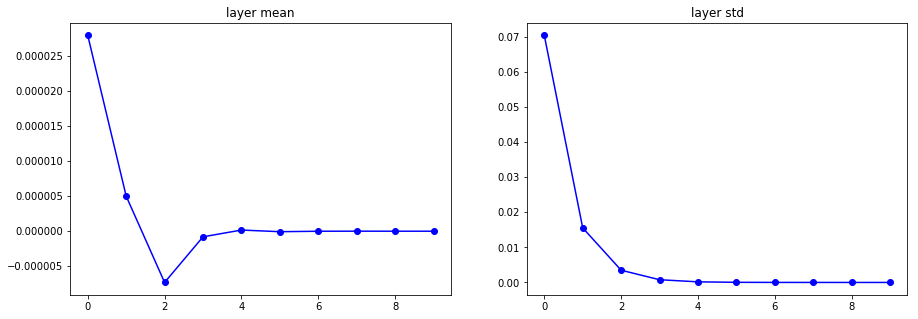

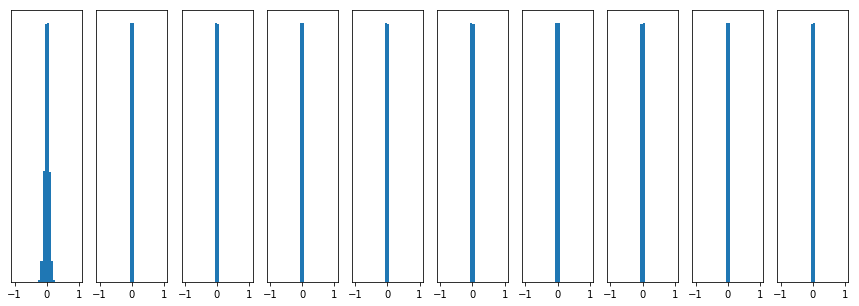

In [26]:
# look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))

layer_means = [np.mean(H) for i, H in Hs.items()]
layer_stds = [np.std(H) for i, H in Hs.items()]

for i, H in Hs.items():
    print('Hidden layer %d had mean %f and std %f' % (i+1, layer_means[i], layer_stds[i]))

# plot the means and standard devirations
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(list(Hs.keys()), list(layer_means), 'ob-')
plt.title('layer mean')
plt.subplot(122)
plt.plot(list(Hs.keys()), list(layer_stds), 'ob-')
plt.title('layer std')

# plot the raw distribution
plt.figure(figsize=(15,5))
for i, H in Hs.items():
    plt.subplot(1, len(Hs)/1, i+1)
    plt.hist(H.ravel(), 30, range=(-1,1))
    plt.yticks([])

### Weights initialization with weight_scale=1.0

Input layer had mean -0.009835 and std 0.999655
Hidden layer 1 had mean -0.000304 and std 0.942059
Hidden layer 2 had mean -0.000662 and std 0.981100
Hidden layer 3 had mean -0.002383 and std 0.981714
Hidden layer 4 had mean -0.000942 and std 0.981582
Hidden layer 5 had mean 0.000667 and std 0.981553
Hidden layer 6 had mean 0.000160 and std 0.981650
Hidden layer 7 had mean -0.000543 and std 0.981648
Hidden layer 8 had mean 0.000555 and std 0.981694
Hidden layer 9 had mean 0.001031 and std 0.981858
Hidden layer 10 had mean 0.001976 and std 0.981491


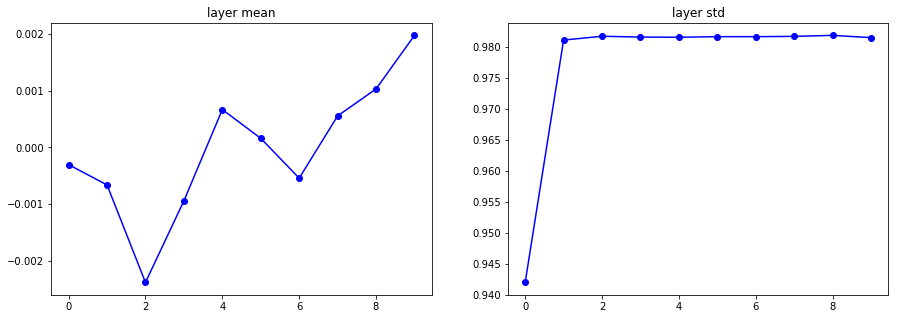

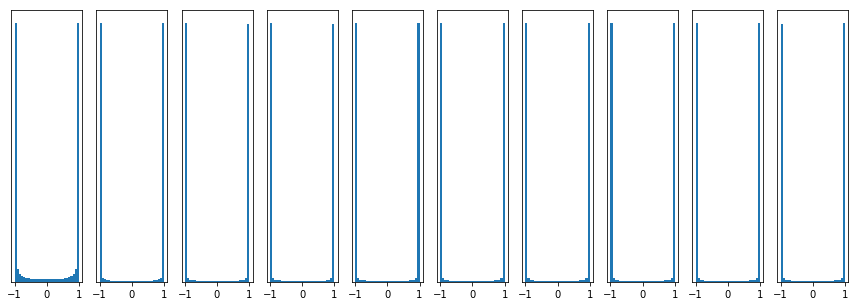

In [27]:
Hs = {}
for i in range(len(hidden_layer_size)):
    X = D if i == 0 else Hs[i-1] # input at this layer
    fan_in = X.shape[1]
    fan_out = hidden_layer_size[i]
    W = np.random.randn(fan_in, fan_out) * 1.0 # layer initialization
    
    H = np.dot(X, W)                 # matrix multiply
    H = act[nonlinearities[i]](H)    # nonlinearity
     
    Hs[i] = H                        # cache result on this layer

# look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))

layer_means = [np.mean(H) for i, H in Hs.items()]
layer_stds = [np.std(H) for i, H in Hs.items()]

for i, H in Hs.items():
    print('Hidden layer %d had mean %f and std %f' % (i+1, layer_means[i], layer_stds[i]))

# plot the means and standard devirations
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(list(Hs.keys()), list(layer_means), 'ob-')
plt.title('layer mean')
plt.subplot(122)
plt.plot(list(Hs.keys()), list(layer_stds), 'ob-')
plt.title('layer std')

# plot the raw distribution
plt.figure(figsize=(15,5))
for i, H in Hs.items():
    plt.subplot(1, len(Hs)/1, i+1)
    plt.hist(H.ravel(), 30, range=(-1,1))
    plt.yticks([])

Almost all neurons completely saturated, either -1 and 1. Gradients will be all zero.

### Weights initialization using Xavier initialization
The nonliearity is **tanh**

Input layer had mean -0.009835 and std 0.999655
Hidden layer 1 had mean -0.001697 and std 0.625897
Hidden layer 2 had mean 0.000089 and std 0.483025
Hidden layer 3 had mean -0.000589 and std 0.407252
Hidden layer 4 had mean 0.000701 and std 0.354488
Hidden layer 5 had mean -0.000701 and std 0.320037
Hidden layer 6 had mean -0.000909 and std 0.292675
Hidden layer 7 had mean 0.000002 and std 0.271632
Hidden layer 8 had mean 0.000335 and std 0.253807
Hidden layer 9 had mean 0.000228 and std 0.238510
Hidden layer 10 had mean 0.000556 and std 0.224329


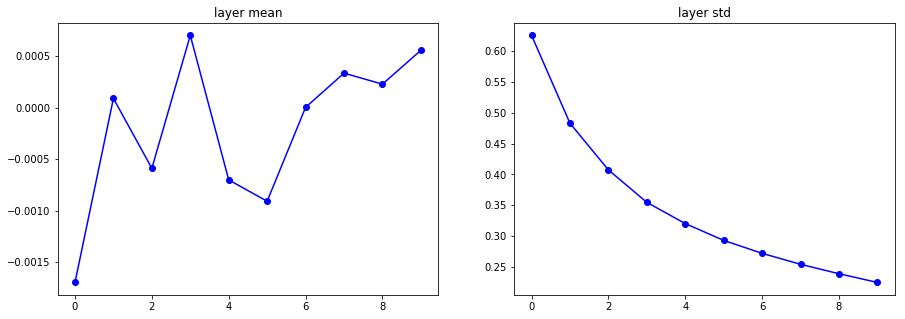

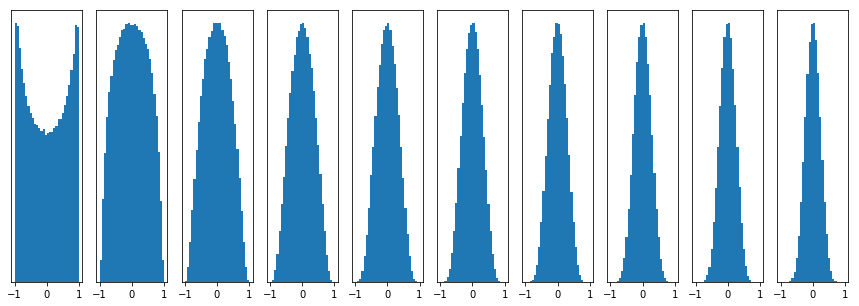

In [28]:
Hs = {}
for i in range(len(hidden_layer_size)):
    X = D if i == 0 else Hs[i-1] # input at this layer
    fan_in = X.shape[1]
    fan_out = hidden_layer_size[i]
    W = np.random.randn(fan_in, fan_out) / np.sqrt(fan_in) # layer initialization
    
    H = np.dot(X, W)                 # matrix multiply
    H = act[nonlinearities[i]](H)    # nonlinearity
     
    Hs[i] = H                        # cache result on this layer

# look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))

layer_means = [np.mean(H) for i, H in Hs.items()]
layer_stds = [np.std(H) for i, H in Hs.items()]

for i, H in Hs.items():
    print('Hidden layer %d had mean %f and std %f' % (i+1, layer_means[i], layer_stds[i]))

# plot the means and standard devirations
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(list(Hs.keys()), list(layer_means), 'ob-')
plt.title('layer mean')
plt.subplot(122)
plt.plot(list(Hs.keys()), list(layer_stds), 'ob-')
plt.title('layer std')

# plot the raw distribution
plt.figure(figsize=(15,5))
for i, H in Hs.items():
    plt.subplot(1, len(Hs)/1, i+1)
    plt.hist(H.ravel(), 30, range=(-1,1))
    plt.yticks([])

Here, we use **Relu**

Input layer had mean -0.009835 and std 0.999655
Hidden layer 1 had mean 0.390061 and std 0.575764
Hidden layer 2 had mean 0.274093 and std 0.404099
Hidden layer 3 had mean 0.199105 and std 0.292556
Hidden layer 4 had mean 0.146142 and std 0.206564
Hidden layer 5 had mean 0.102439 and std 0.154969
Hidden layer 6 had mean 0.078792 and std 0.117304
Hidden layer 7 had mean 0.056759 and std 0.081061
Hidden layer 8 had mean 0.040282 and std 0.060070
Hidden layer 9 had mean 0.028873 and std 0.042840
Hidden layer 10 had mean 0.022182 and std 0.033295


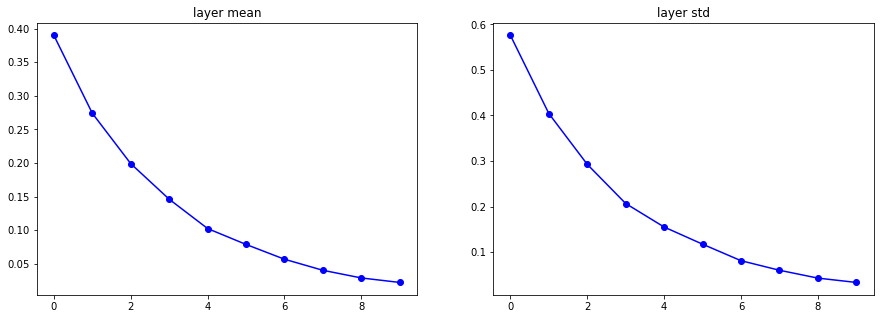

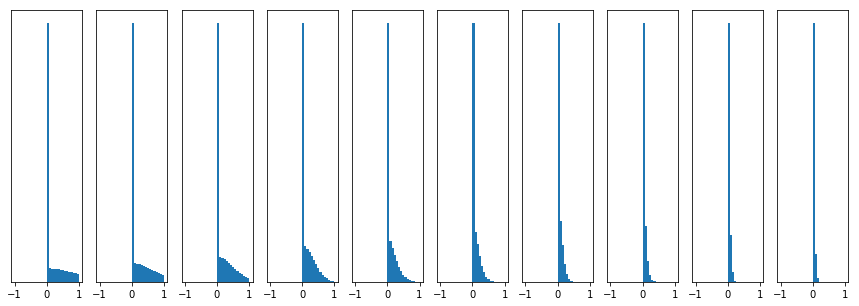

In [29]:
nonlinearities = ['relu']*len(hidden_layer_size)
Hs = {}
for i in range(len(hidden_layer_size)):
    X = D if i == 0 else Hs[i-1] # input at this layer
    fan_in = X.shape[1]
    fan_out = hidden_layer_size[i]
    W = np.random.randn(fan_in, fan_out) / np.sqrt(fan_in) # layer initialization
    
    H = np.dot(X, W)                 # matrix multiply
    H = act[nonlinearities[i]](H)    # nonlinearity
     
    Hs[i] = H                        # cache result on this layer

# look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))

layer_means = [np.mean(H) for i, H in Hs.items()]
layer_stds = [np.std(H) for i, H in Hs.items()]

for i, H in Hs.items():
    print('Hidden layer %d had mean %f and std %f' % (i+1, layer_means[i], layer_stds[i]))

# plot the means and standard devirations
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(list(Hs.keys()), list(layer_means), 'ob-')
plt.title('layer mean')
plt.subplot(122)
plt.plot(list(Hs.keys()), list(layer_stds), 'ob-')
plt.title('layer std')

# plot the raw distribution
plt.figure(figsize=(15,5))
for i, H in Hs.items():
    plt.subplot(1, len(Hs)/1, i+1)
    plt.hist(H.ravel(), 30, range=(-1,1))
    plt.yticks([])

### Weights initialization using modified Xavier initialization

Input layer had mean -0.009835 and std 0.999655
Hidden layer 1 had mean 0.559233 and std 0.825998
Hidden layer 2 had mean 0.568784 and std 0.839073
Hidden layer 3 had mean 0.554230 and std 0.823583
Hidden layer 4 had mean 0.535445 and std 0.786475
Hidden layer 5 had mean 0.511438 and std 0.773527
Hidden layer 6 had mean 0.508626 and std 0.767877
Hidden layer 7 had mean 0.500853 and std 0.739665
Hidden layer 8 had mean 0.512550 and std 0.753543
Hidden layer 9 had mean 0.507254 and std 0.780131
Hidden layer 10 had mean 0.515842 and std 0.751853


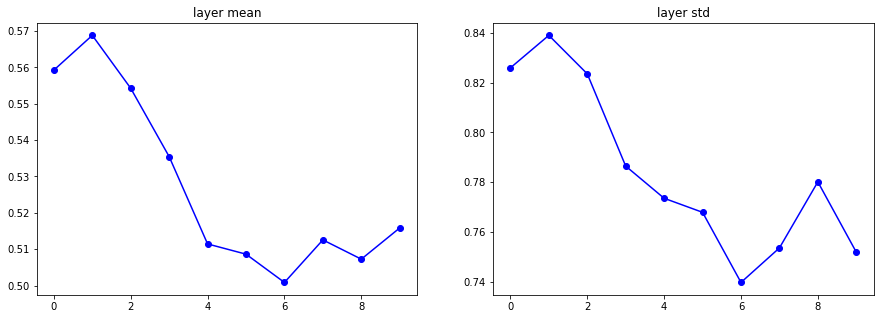

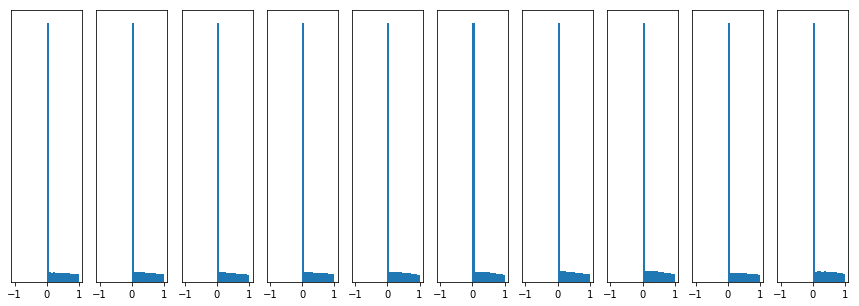

In [30]:
nonlinearities = ['relu']*len(hidden_layer_size)
Hs = {}
for i in range(len(hidden_layer_size)):
    X = D if i == 0 else Hs[i-1] # input at this layer
    fan_in = X.shape[1]
    fan_out = hidden_layer_size[i]
    W = np.random.randn(fan_in, fan_out) / np.sqrt(fan_in/2) # layer initialization
    
    H = np.dot(X, W)                 # matrix multiply
    H = act[nonlinearities[i]](H)    # nonlinearity
     
    Hs[i] = H                        # cache result on this layer

# look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))

layer_means = [np.mean(H) for i, H in Hs.items()]
layer_stds = [np.std(H) for i, H in Hs.items()]

for i, H in Hs.items():
    print('Hidden layer %d had mean %f and std %f' % (i+1, layer_means[i], layer_stds[i]))

# plot the means and standard devirations
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(list(Hs.keys()), list(layer_means), 'ob-')
plt.title('layer mean')
plt.subplot(122)
plt.plot(list(Hs.keys()), list(layer_stds), 'ob-')
plt.title('layer std')

# plot the raw distribution
plt.figure(figsize=(15,5))
for i, H in Hs.items():
    plt.subplot(1, len(Hs)/1, i+1)
    plt.hist(H.ravel(), 30, range=(-1,1))
    plt.yticks([])

Input layer had mean -0.009835 and std 0.999655
Hidden layer 1 had mean 0.000396 and std 0.624542
Hidden layer 2 had mean 0.000269 and std 0.479801
Hidden layer 3 had mean -0.000823 and std 0.404073
Hidden layer 4 had mean 0.000320 and std 0.354213
Hidden layer 5 had mean 0.000506 and std 0.318498
Hidden layer 6 had mean 0.000277 and std 0.289739
Hidden layer 7 had mean 0.000445 and std 0.269115
Hidden layer 8 had mean -0.000325 and std 0.251703
Hidden layer 9 had mean 0.000382 and std 0.240530
Hidden layer 10 had mean -0.000116 and std 0.228191


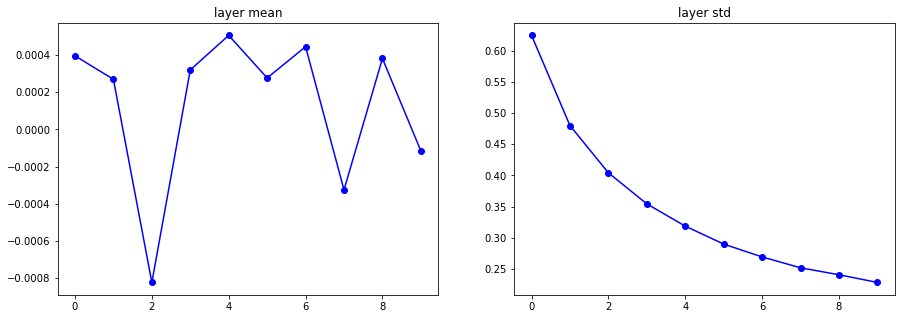

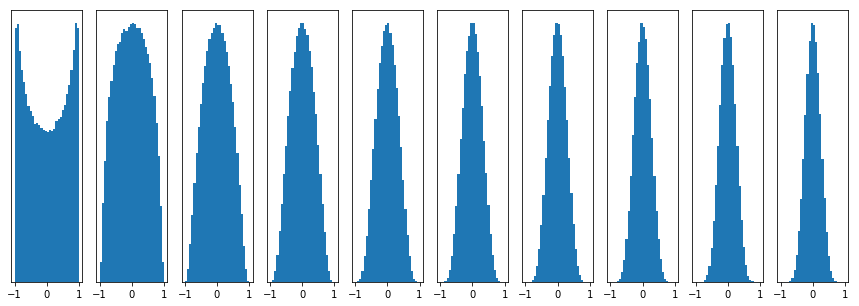

In [31]:
nonlinearities = ['tanh']*len(hidden_layer_size)
Hs = {}
for i in range(len(hidden_layer_size)):
    X = D if i == 0 else Hs[i-1] # input at this layer
    fan_in = X.shape[1]
    fan_out = hidden_layer_size[i]
    W = np.random.randn(fan_in, fan_out) / np.sqrt(fan_in) # layer initialization
    
    H = np.dot(X, W)                 # matrix multiply
    H = act[nonlinearities[i]](H)    # nonlinearity
     
    Hs[i] = H                        # cache result on this layer

# look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))

layer_means = [np.mean(H) for i, H in Hs.items()]
layer_stds = [np.std(H) for i, H in Hs.items()]

for i, H in Hs.items():
    print('Hidden layer %d had mean %f and std %f' % (i+1, layer_means[i], layer_stds[i]))

# plot the means and standard devirations
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(list(Hs.keys()), list(layer_means), 'ob-')
plt.title('layer mean')
plt.subplot(122)
plt.plot(list(Hs.keys()), list(layer_stds), 'ob-')
plt.title('layer std')

# plot the raw distribution
plt.figure(figsize=(15,5))
for i, H in Hs.items():
    plt.subplot(1, len(Hs)/1, i+1)
    plt.hist(H.ravel(), 30, range=(-1,1))
    plt.yticks([])